# Machine Learning: Time Series Modeling

This notebook highlights the steps taken to perform a time series analysis. 

## The Setting

Utility companies are investing heavily in demand response programs and initiatives. Currently, these companies are supplying excess energy and as a result, they are experiencing high operational costs and producing large amounts of CO2 pollution.

These companies are striving to limit the supply of excess energy,  lower their operational costs and reduce their carbon footprint. To that end, these companies are leveeraging machine learning to aid them in understanding consumer behavior.

The goal of this analysis is to understand the energy usage patterns within a household and to predict energy usage on a holdout set based on historical data.

This notebook will highlight several time series forecasting techniques and compare how well these algorithms perform.

## The Data

The dataset was obtained from [kaggle.](https://www.kaggle.com/datasets/jaganadhg/house-hold-energy-data?resource=download) The data was collected from the uploader's apartment in San Jose for over 2 years. The data was collected with smart meters and shared by the energy company. 

## Data Attributes

The dataset has the following eight attributes:


* TYPE - This is an information column. The value is 'Electric usage' for all the observations.
* DATE - Date of electric consumption. There is no timestamp in this field.
* START TIME - Start time of the consumption.
* END TIME - End time of the consumption
* USAGE - Consumption in kWh
* UNITS - This column denotes measurement unit. It is kWh for all the observations.
* COST - Cost of consumption in $.
* NOTES - Mostly an empty column

In [1]:
# Import Libraries

from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels
import seaborn as sns
import pmdarima as pm
%matplotlib inline

In [2]:
#load the data
data = pd.read_csv('D202.csv', parse_dates = {'DATE_TIME': ['DATE', 'START TIME']})

data.head()

,DATE_TIME,TYPE,END TIME,USAGE,UNITS,COST,NOTES
0,2016-10-22 00:00:00,Electric usage,0:14,0.01,kWh,$0.00,NaN
1,2016-10-22 00:15:00,Electric usage,0:29,0.01,kWh,$0.00,NaN
2,2016-10-22 00:30:00,Electric usage,0:44,0.01,kWh,$0.00,NaN
3,2016-10-22 00:45:00,Electric usage,0:59,0.01,kWh,$0.00,NaN
4,2016-10-22 01:00:00,Electric usage,1:14,0.01,kWh,$0.00,NaN


## Exploratory Data Analysis

In [3]:
data.shape

(70368, 7)

In [4]:
data.dtypes

DATE_TIME    datetime64[ns]
TYPE                 object
END TIME             object
USAGE               float64
UNITS                object
COST                 object
NOTES               float64
dtype: object

In [5]:
# specify the columns needed for the analysis
df = data[['DATE_TIME', 'USAGE']]

df.set_index('DATE_TIME', inplace = True)
df.tail()

,USAGE
DATE_TIME,
2018-10-24 22:45:00,0.02
2018-10-24 23:00:00,0.03
2018-10-24 23:15:00,0.03
2018-10-24 23:30:00,0.03
2018-10-24 23:45:00,0.03


In [6]:
df.isnull().sum()

USAGE    0
dtype: int64

## Check for Stationarity



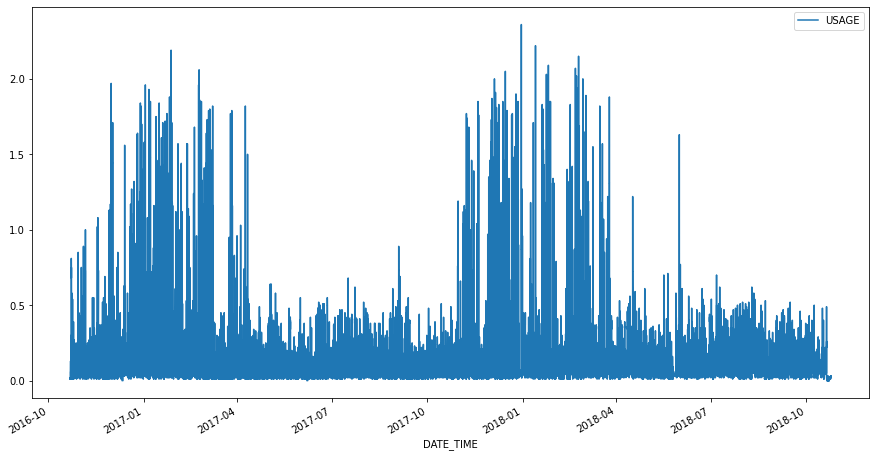

In [7]:
df.plot(figsize = (15, 8))
plt.show()

The data contains a seasonal pattern whereby the usage increases drastically during the winter months as well as some heteroscedasticity.

### Summary Statistics

In [65]:
# segment the data into chunks to check the mean and variance
splits = 12
chunks = np.split(df['USAGE'], indices_or_sections = splits)

print( 'mean val' ,np.mean(chunks, axis=1), '\n')
print('variance vals', np.var(chunks, axis = 1))
vals = {'mean vals':np.mean(chunks, axis=1), 'variance vals': np.var(chunks, axis=1)}

mean val [0.14744884 0.21758527 0.11745566 0.07660982 0.09012278 0.08081855
 0.1518895  0.15592087 0.14172578 0.09630969 0.10442019 0.0829809 ] 

variance vals [0.04252869 0.1093954  0.0669996  0.00960222 0.01142604 0.0101449
 0.09348313 0.08421297 0.05244266 0.01283324 0.01221361 0.00696622]


In [11]:
vals = {'mean vals':np.mean(chunks, axis=1), 'variance vals': np.var(chunks, axis=1)}
vals_df = pd.DataFrame(vals)
vals_df

,mean vals,variance vals
0,0.147449,0.042529
1,0.217585,0.109395
2,0.117456,0.067000
3,0.076610,0.009602
4,0.090123,0.011426
5,0.080819,0.010145
6,0.151889,0.093483
7,0.155921,0.084213
8,0.141726,0.052443
9,0.096310,0.012833


<function matplotlib.pyplot.show(close=None, block=None)>

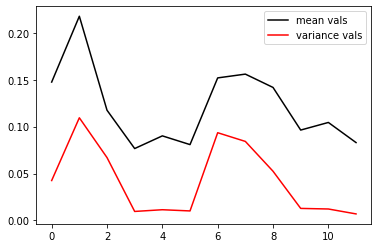

In [12]:
plt.plot(range(len(np.mean(chunks, axis=1))), np.mean(chunks, axis=1), 'k-', label = 'mean vals')
plt.plot(range(len(np.mean(chunks, axis=1))), np.var(chunks, axis=1), 'r-', label = 'variance vals')
plt.legend()
plt.show

Neither the mean nor the variance change drastically 

### Augmented Dickel-Fuller test

In [13]:
from statsmodels.tsa.stattools import adfuller

adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(df['USAGE'])

In [14]:
print('adf', adf)
print('pvalue', pvalue)

adf -25.238587018974542
pvalue 0.0


With a p value of 0, the null hypothesis is rejected. This suggests that the data is stationary, but there seems to be a trend and seasonailty component, which will be removed.

### Removing Trend and Seasonality

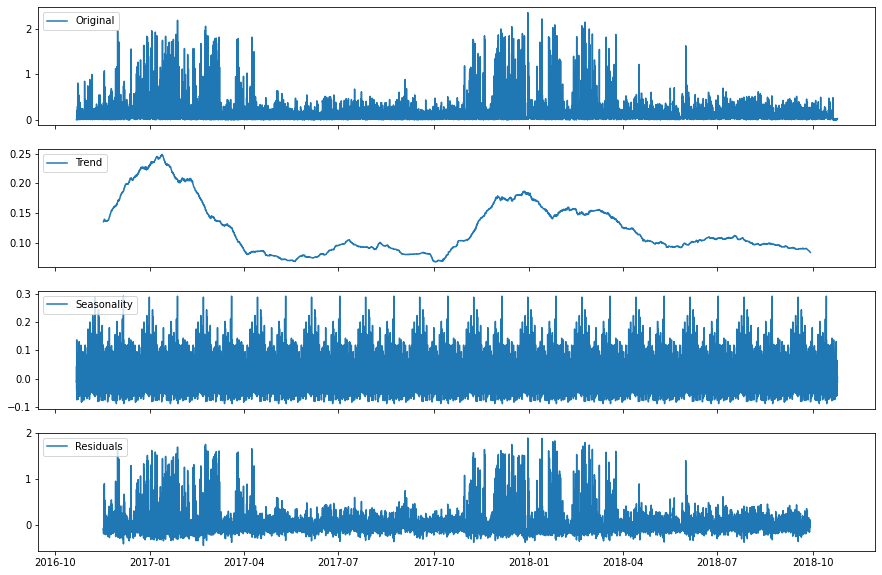

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

ss_decomposition = seasonal_decompose(x=df['USAGE'], model='additive', period=5000)
estimated_trend = ss_decomposition.trend
estimated_seasonal = ss_decomposition.seasonal
estimated_residual = ss_decomposition.resid

fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(df['USAGE'], label='Original')
axes[0].legend(loc='upper left');

axes[1].plot(estimated_trend, label='Trend')
axes[1].legend(loc='upper left');

axes[2].plot(estimated_seasonal, label='Seasonality')
axes[2].legend(loc='upper left');

axes[3].plot(estimated_residual, label='Residuals')
axes[3].legend(loc='upper left');

In [16]:
#estimated_residual[2500:-2500]

adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(estimated_residual[2500:-2500])
print('adf', adf)
print('pvalue', pvalue)

adf -28.93409749084728
pvalue 0.0


Looking at residuals, the ADF test returns slightly better results. This suggests that the original data is stationary. So the original data will be used in the time series analysis.

## Time Series Analysis

As mentioned before, this notebook will highlight several time series forecasting techniques to predict future energy consumption. The performance these techniwues will be quantified using the mean square error metric. The technique that produces the lowest mean square error is most most suitable of this analysis.

In [17]:
# create a mean square error function

def mse(observations, estimates):
    
    # check arg types
    assert type(observations) == type(np.array([])), "'observations' must be a numpy array"
    assert type(estimates) == type(np.array([])), "'estimates' must be a numpy array"
    # check length of arrays equal
    assert len(observations) == len(estimates), "Arrays must be of equal length"
    
    # calculations
    difference = observations - estimates
    sq_diff = difference ** 2
    mse = sum(sq_diff)
    
    return mse

In [66]:
# test/ train split
my_time = np.arange(len(df['USAGE']))
test_size = 5000

train = np.array(df['USAGE'])[:-test_size]
test = np.array(df['USAGE'])[-test_size:]

print('train set' ,len(train))
print('test set' ,len(test))

train set 65368
test set 5000


In [70]:
# plotting function

import matplotlib.dates as mdates

def make_plot(preds, model):
    
    pfig = plt.figure(figsize=(15,6))
    plt.plot(my_time[:-test_size] ,train, label = 'train')
    plt.plot(my_time[-test_size:] , test, label = 'test')
    plt.plot( my_time[-test_size:] , preds, label = 'pred')
    plt.xlim(58000,72000)
    plt.legend()
    plt.title(model)

### Model 1: Single Exponentail Smoothing

The first forcasting technique introduced will be the single exponential smoothing technique. 

In [71]:
from statsmodels.tsa.api import SimpleExpSmoothing

single = SimpleExpSmoothing(train).fit(optimized=True)
single_preds = single.forecast(len(test))
single_mse = mse(test, single_preds)
single_mse

39.936799999998115

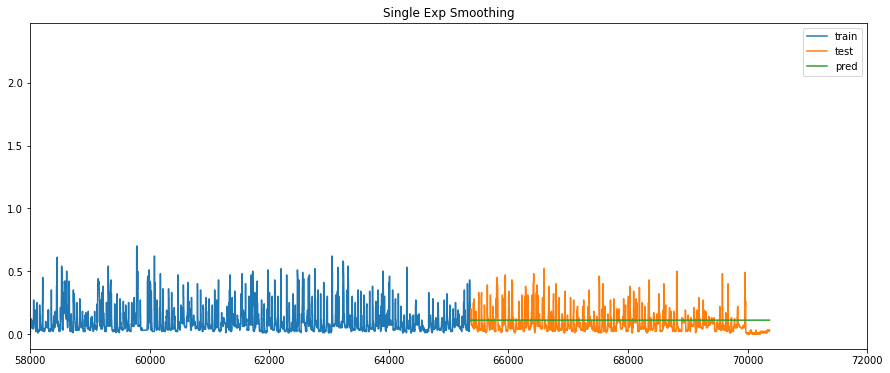

In [72]:
make_plot(single_preds, 'Single Exp Smoothing')

### Model 2: Triple Exponentail Smoothing

The second model analyzed is the triple exponential smoothing model. As parameters for this model, trend and the seasonal component were chosen `additive`

In [73]:
from statsmodels.tsa.api import ExponentialSmoothing

triple = ExponentialSmoothing(train,
                            trend = 'additive',
                            seasonal = 'additive',
                            seasonal_periods= 600).fit(optimized=True)

triple_preds = triple.forecast(len(test))
triple_mse = mse(test, triple_preds)
triple_mse

C:\Users\chuce\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


40.17593180634345

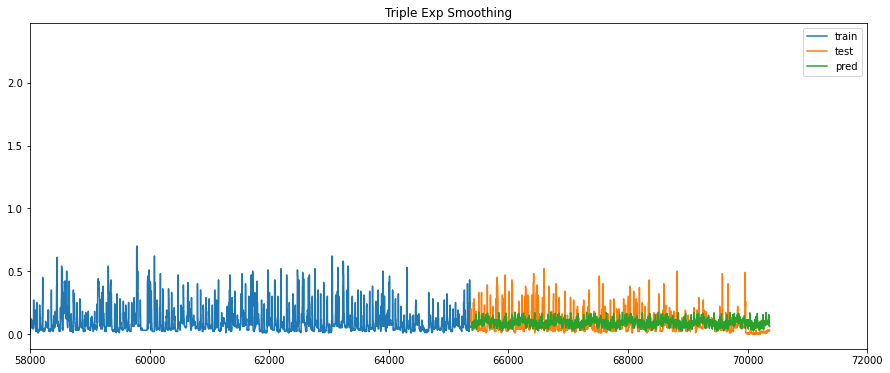

In [74]:
make_plot(triple_preds, 'Triple Exp Smoothing')

### Model 3: SARIMA Model

The third model will be a SARIMA model. The number of autoregressive and moving average terms, p and q respectively, will be determined by plotiing the autocorrelation and partial autocorrelation function.

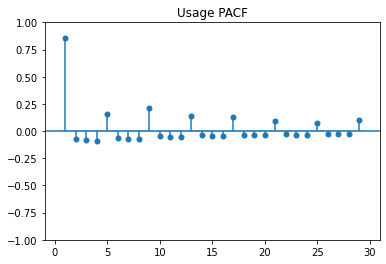

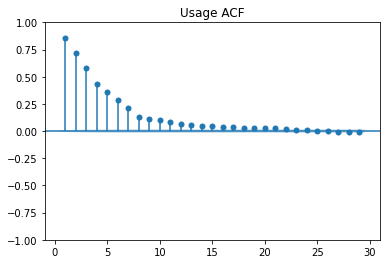

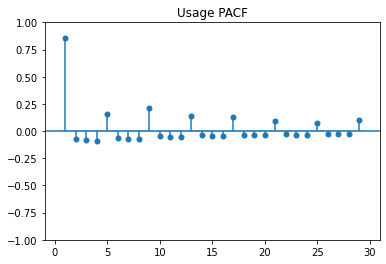

In [86]:
statsmodels.api.tsa.graphics.plot_acf(df['USAGE'], lags=range(1,30), alpha=0.05,title = 'Usage ACF')
statsmodels.api.tsa.graphics.plot_pacf(df['USAGE'], lags=range(1,30), alpha=0.05,title = 'Usage PACF')

In [75]:
sar = statsmodels.tsa.statespace.sarimax.SARIMAX(train, 
                                                order=(1,0,0), 
                                                seasonal_order=(1,0,0,30), 
                                                trend='c').fit()

In [78]:
preds_sar = sar.predict(start = 65368, end = 70367, dynamic = False)
sar_mse = mse(test, preds_sar)
sar_mse

44.92884235481409

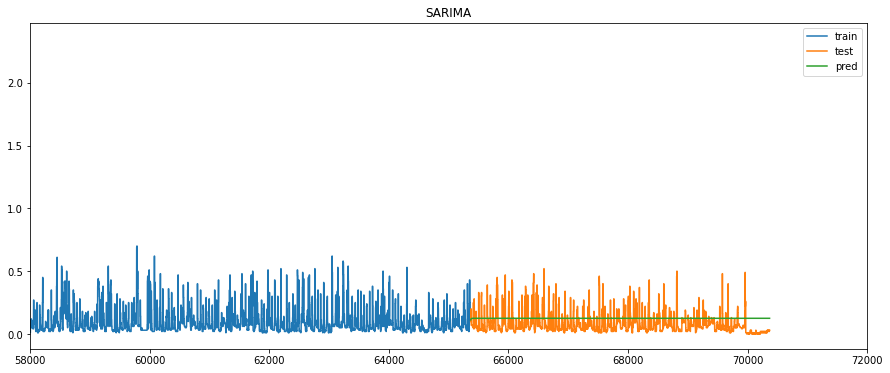

In [79]:
make_plot(preds_sar, 'SARIMA')

## Discussion

The three models performed similarly in which the mean square error from the models ranged from 39.9 - 44.9. It is important to note that model 2, triple exponential smoothing, did not fully converge. This was possibly due to the large number of seasonal periods being fitted. This large number was chosen in order to fit the large training set.

The ACF and PACF graphs show very significant correlation values. The ACF graphs shows lag 1 exibits a strong correlation; leading to a slow decay. This suggest that this model was an AR(1) model.

Both model 2 and 3 were time consuming to train. Again the large training coupled with a large amounts of seasonal periods led to slow convergence. With that said, model 1 and 3 made predictions that remained constant. This suggests that these models are underfit and should be tuned for better results.

For this dataset, a deep learning analysis would be more suitable. Unfortunately due to hardware limitations, building a deep learning model was not possible.



## Conclusion

On completing this analysis, the three models performed similarily. As there was a large maount of large to analyze, a deep learning model would be more suitable, whether recursive neural networks or long short term memory algorithm. Unfortunately, hardward limitations prohibited the development of a deep learning model, so other algorithms were utilized.

Considerations for future work wwould include training deep learning models as they are more suited for large datasets. Additionally, along with training a DL model, forecasting future values of energy usage should be considered.

# Thank you for reading this notebook